<a href="https://colab.research.google.com/github/saddam-satria/classification/blob/main/Titanic_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Package Python


In [ ]:
 
 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder,PolynomialFeatures
from sklearn.ensemble import  RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
 
from jcopml.feature_importance import mean_score_decrease,mean_loss_decrease
from jcopml.tuning import grid_search_params as gsp
from jcopml.plot import plot_actual_vs_prediction

### Data Training


In [ ]:
from google.colab import files
file = files.upload()

Saving train.csv to train.csv


In [ ]:
import io
df_train = pd.read_csv(io.BytesIO(file['train.csv']),index_col='PassengerId')

In [ ]:
df_train.drop(columns= ['Ticket','Cabin'],inplace=True)
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [ ]:
df_train['Alone'] = (df_train.Parch ==0)&(df_train.SibSp == 0)
df_train.Alone = df_train.Alone.astype(int)
df_train['Title'] = df_train.Name.apply(lambda x: (x.split(", ")[1]).split(".")[0])

In [ ]:
def rubah_title(x):
  if x in ['Mr','Mrs','Miss','Master']:
    return x
  else: 
    return "Other"

In [ ]:
df_train['Title'] = df_train.Title.apply(rubah_title)
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Alone,Title
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,0,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,0,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,0,Mrs
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,Mr


In [ ]:
df_train.Title.value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Other      27
Name: Title, dtype: int64

### Data Splitting


In [ ]:
xTr = df_train.drop(columns="Survived")
yTr = df_train['Survived']
 
xTr.drop(columns='Name',inplace=True)

In [ ]:
xTr.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Alone,Title
PassengerId,,,,,,,,,
1,3,male,22.0,1,0,7.2500,S,0,Mr
2,1,female,38.0,1,0,71.2833,C,0,Mrs
3,3,female,26.0,0,0,7.9250,S,1,Miss
4,1,female,35.0,1,0,53.1000,S,0,Mrs
5,3,male,35.0,0,0,8.0500,S,1,Mr




### Data Testing



In [ ]:
file_test = files.upload()

Saving test.csv to test.csv


In [ ]:
df_test = pd.read_csv(io.BytesIO(file_test['test.csv']),index_col='PassengerId')
df_test.drop(columns=['Cabin','Ticket'], inplace=True)

In [ ]:
df_test['Alone'] = (df_test.Parch ==0)&(df_test.SibSp == 0)
df_test.Alone = df_test.Alone.astype(int)
df_test['Title'] = df_test.Name.apply(lambda x: (x.split(", ")[1]).split(".")[0])
df_test.drop(columns='Name',inplace=True)

In [ ]:
xTs = df_test
xTs.Title = xTs.Title.apply(rubah_title)

In [ ]:
xTs.shape

(418, 9)

In [ ]:
xTr.shape

(891, 9)

### Modeling

In [ ]:
 num_pip = Pipeline([
   ("impute", SimpleImputer (strategy='mean')),#fillna
   ("Scale", StandardScaler()),#scaling
   ("Poly", PolynomialFeatures (degree=2))
])
 
cat_pip = Pipeline([
   ("impute", SimpleImputer (strategy="most_frequent")),
   ("Encode", OneHotEncoder ())
])
 
 
preprocessor = ColumnTransformer([       
        ("numeric",num_pip,['Pclass','SibSp', 'Fare','Alone','Age']),     
        ("kategorik",cat_pip,['Sex','Title'])
])
 
 
pipeline=Pipeline ([       
        ("prep", preprocessor),       
        ("model", RandomForestClassifier(n_jobs=-1, random_state=42,))
])
 
parameters= {
    'model__n_estimators':range(100,200,50),
    'model__max_depth': [3,8,12],
    'model__min_samples_leaf':[2,5,7],
    'model__min_samples_split': [2,5,10]
}
 
 
model = GridSearchCV(pipeline,parameters,cv=3,n_jobs=-1, verbose=1)
model.fit(xTr,yTr)
 
print(model.best_params_)
model.best_score_,model.score(xTr,yTr)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   45.0s finished


{'model__max_depth': 8, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 150}


(0.8350168350168349, 0.9090909090909091)

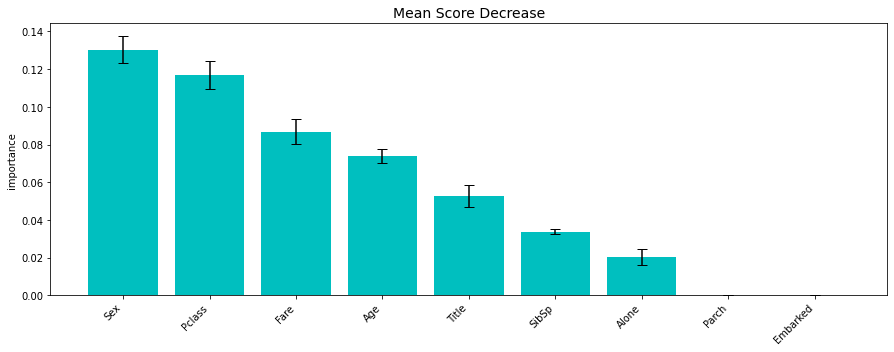

In [ ]:
df_imp = mean_score_decrease(xTr,yTr,model,plot=True,topk=10)

In [ ]:
 
yTs = model.predict(xTs)

Evaluasi model

In [ ]:
file_subs = files.upload()

Saving gender_submission.csv to gender_submission.csv


In [ ]:
df_subs = pd.read_csv(io.BytesIO(file_subs['gender_submission.csv']))

In [ ]:
df_subs['Prediksi'] = yTs
yTrue = df_subs['Survived']
yPred= df_subs['Prediksi']

In [ ]:
print(confusion_matrix(yTrue,yPred))
print(accuracy_score(yTrue,yPred))

[[243  23]
 [ 26 126]]
0.8827751196172249


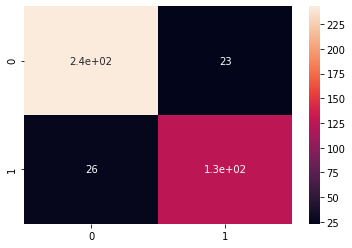

In [ ]:
sns.heatmap(confusion_matrix(yTrue,yPred),annot=True)

In [ ]:
subsmission = {
        'PassengerId':df_subs.PassengerId,
                    'Survived': yPred
 
}
 
df_subsmission= pd.DataFrame(subsmission, columns=['PassengerId',"Survived"])

In [ ]:
df_subsmission.to_csv("subsmission.csv")
 
files.download("subsmission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
a = files.upload()

Saving subsmission.csv to subsmission (1).csv


In [ ]:
dff=pd.read_csv(io.BytesIO(a['subsmission.csv']),index_col='PassengerId')

In [ ]:
dff.drop(columns='Unnamed: 0',inplace=True)

In [ ]:
dff.to_csv('submission.csv')

In [ ]:
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>